## import modules

In [1]:
from mikit.compname import ChemFormula, TriChemFormula
from mikit.feature import CreateFeature
from mikit.mlops import WrapperMethod
from mikit.trigraph import TriGraph

import pandas as pd
import numpy as np
import pickle

## Loading data and model

In [2]:
df_learning = pd.read_pickle("./data/df_learning_lasso.pkl")
df_y = pd.read_csv("./data/learning.csv", index_col="X")
model = pickle.load(open("./data/lasso_model.sav", 'rb'))

## Creating a feature set of the composition you want to predict

In [3]:
# creating chemical formula
atoms = ["Pb", "Sn", "La"]
tcf = TriChemFormula()
comp = tcf.get_tri_name(atoms, delta = 0.1)

# creating moler ratio
cn = ChemFormula()

# all, only F, not F
all_molratio = cn.get_molratio(comp)
f_molratio = cn.get_molratio(comp, tar_atoms=["F"])
cation_molratio = cn.get_molratio(comp, exc_atoms=["F"])

# creating molratio(dict)
dict_molratio = {
    "All" : all_molratio,
    "F" : f_molratio,
    "Cation" : cation_molratio
    }

# creating features of composition
cf = CreateFeature()

# get average features
dict_feature = cf.get_ave_features(dict_molratio)

# adding std features
dict_feature.update(cf.get_std_features(dict_molratio, exc=["F", "All"]))

# adding max features
dict_feature.update(cf.get_max_features(dict_molratio, exc=["F"]))

# adding min features
dict_feature.update(cf.get_min_features(dict_molratio, exc=["F"]))

# creating a new feature
dict_feature["Cation(Ave)/F(Ave)"] = dict_feature["Cation(Ave)"] / dict_feature["F(Ave)"]
dict_feature["All(Max)/F(Ave)"] = dict_feature["All(Max)"] / dict_feature["F(Ave)"]
dict_feature["All(Min)/F(Ave)"] = dict_feature["All(Min)"] / dict_feature["F(Ave)"]

# creating dataframe of predicting
df = cf.get_df_learning(dict_feature, comp)
df = df[df_learning.columns.values]

## Predicting conductivity

In [4]:
# print(df_learning.columns.values.shape)
y_pre = model.predict(df.values)

## Outputing a triangle diagram

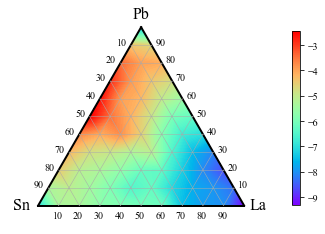

In [5]:
pseudo_ratio = tcf.get_only_pseudo_ratio(comp,  atoms)
tg = TriGraph(atoms)
tg.add_contourf(pseudo_ratio, y_pre)

## Addinng plot of learnig data

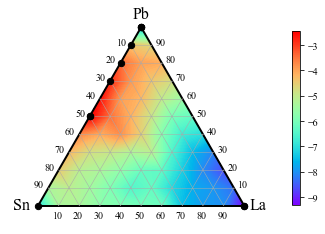

In [6]:
add_comp = cn.get_tar_name(df_learning.index.values, atoms)
add_ratio = tcf.get_only_pseudo_ratio(add_comp, atoms)
tg.add_plot(add_ratio)
tg.get_graph()

## Comparison with learning data

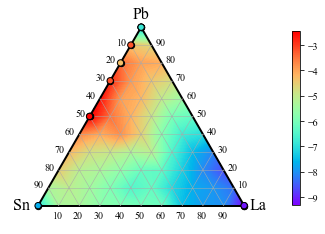

In [7]:
# Extraction of the objective variable in a three-component system
set_add_comp = sorted(set(add_comp), key=add_comp.index)
y_learning = df_y.loc[set_add_comp].values

# Adding a plot
tg.add_plot(add_ratio, y_learning)
tg.get_graph()